<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/06_transfer_learning_tf_scale_up_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-27 10:40:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-27 10:40:23 (52.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Import packages, download and unzip data

In [ ]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

IMG_SIZE=(224,224)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"



--2022-07-27 10:40:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 108.177.11.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  96.9MB/s    in 14s     

2022-07-27 10:40:42 (107 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



## Setup data loaders for train and test data

In [ ]:

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Setup Model Checkpoint and augment the data

We have to compare a feature extractor for 10 epochs, against a 5-epoch feature extractor consecuted by another 5 epochs of a fined tuned model.

Therefore we will set up a checkpoint after 5 epochs. 

In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

### Data Augmentation 

In [ ]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
], name="data_augmentation")

## Setup model architecture

In [ ]:
# Setup base model (with no top) and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Setup model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SIZE + (3,), name="inptu_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs,outputs)

## Compile, train and evalaute model

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inptu_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Train model for first 5 epochs 

In [ ]:
initial_epochs = 5

history_common = model.fit(train_data,
                           epochs=initial_epochs,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=int(0.25*len(test_data)),
                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 55s 156ms/step - loss: 3.4854 - accuracy: 0.2418 - val_loss: 2.4551 - val_accuracy: 0.4370
Epoch 2/5
237/237 [==============================] - 31s 129ms/step - loss: 2.3524 - accuracy: 0.4553 - val_loss: 2.0217 - val_accuracy: 0.5051
Epoch 3/5
237/237 [==============================] - 30s 126ms/step - loss: 1.9932 - accuracy: 0.5241 - val_loss: 1.8595 - val_accuracy: 0.5287
Epoch 4/5
237/237 [==============================] - 29s 120ms/step - loss: 1.7615 - accuracy: 0.5694 - val_loss: 1.7658 - val_accuracy: 0.5436
Epoch 5/5
237/237 [==============================] - 28s 117ms/step - loss: 1.6064 - accuracy: 0.6025 - val_loss: 1.7156 - val_accuracy: 0.5504


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 40s 50ms/step - loss: 1.7328 - accuracy: 0.5480


[1.7327840328216553, 0.5479999780654907]

### Train model for next five epochs

Model weights are loaded for formalities

In [ ]:
model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [ ]:
history_featex_next_5 = model.fit(train_data,
                                  epochs=10,
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  initial_epoch=history_common.epoch[-1])

Epoch 5/10
237/237 [==============================] - 27s 111ms/step - loss: 1.4836 - accuracy: 0.6382 - val_loss: 1.6852 - val_accuracy: 0.5554
Epoch 6/10
237/237 [==============================] - 26s 110ms/step - loss: 1.3716 - accuracy: 0.6632 - val_loss: 1.6613 - val_accuracy: 0.5530
Epoch 7/10
237/237 [==============================] - 26s 108ms/step - loss: 1.2909 - accuracy: 0.6764 - val_loss: 1.6465 - val_accuracy: 0.5635
Epoch 8/10
237/237 [==============================] - 26s 108ms/step - loss: 1.2159 - accuracy: 0.6970 - val_loss: 1.6457 - val_accuracy: 0.5606
Epoch 9/10
237/237 [==============================] - 26s 107ms/step - loss: 1.1498 - accuracy: 0.7114 - val_loss: 1.6279 - val_accuracy: 0.5688
Epoch 10/10
237/237 [==============================] - 25s 106ms/step - loss: 1.0758 - accuracy: 0.7340 - val_loss: 1.6319 - val_accuracy: 0.5652


### Evaluate Model

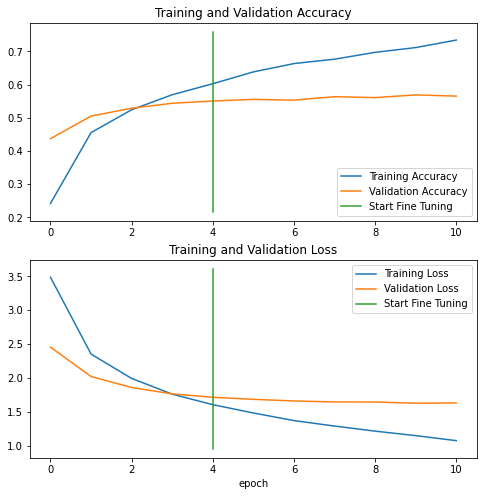

In [ ]:
compare_historys(history_common, 
                 history_featex_next_5,
                 initial_epochs=5)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 39s 49ms/step - loss: 1.6984 - accuracy: 0.5566


[1.698429822921753, 0.5566336512565613]

We observe that after continuing training the model for another five epochs, accuracy kept improving only in the train data. Slight improvement is observed in the validation data and no noticeable change was perceived after the start of the fine tuning, because there was no fine tuning in this case. Next we will compare accuracies with fine tuning.

## Fine-tuned model 

Finetuning a model normally starts off a feature extractor.
For fine tuning, we need to be able to change some weights from the pretrained base model, and therefore we need to access its layers and make them trainable. 

For ease, we first declare all base model's layers as trainable, then loop through the base model's layers until the last x number of layers we want to allow to be fine tuned to our dataset. Fine tuning should improve model overfitting that was experienced after 10 epochs from our trained feature extractor model.

Now we make the last 30 layers from the base model as trainable

In [ ]:
base_model.trainable = False

for layer in model.layers[2].layers[:30]:
  layer.trainable = False


In [ ]:
model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
history_finetuned_next5 = model.fit(train_data,
                                    epochs=10,
                                    validation_data=test_data,
                                    validation_steps=int(0.25*len(test_data)),
                                    initial_epoch=history_common.epoch[-1])

Epoch 5/10
237/237 [==============================] - 33s 111ms/step - loss: 1.4293 - accuracy: 0.6570 - val_loss: 1.6798 - val_accuracy: 0.5562
Epoch 6/10
237/237 [==============================] - 25s 105ms/step - loss: 1.4136 - accuracy: 0.6677 - val_loss: 1.6676 - val_accuracy: 0.5608
Epoch 7/10
237/237 [==============================] - 25s 103ms/step - loss: 1.4117 - accuracy: 0.6640 - val_loss: 1.6615 - val_accuracy: 0.5609
Epoch 8/10
237/237 [==============================] - 25s 103ms/step - loss: 1.3924 - accuracy: 0.6730 - val_loss: 1.6571 - val_accuracy: 0.5619
Epoch 9/10
237/237 [==============================] - 24s 101ms/step - loss: 1.3777 - accuracy: 0.6700 - val_loss: 1.6543 - val_accuracy: 0.5641
Epoch 10/10
237/237 [==============================] - 24s 102ms/step - loss: 1.3598 - accuracy: 0.6751 - val_loss: 1.6521 - val_accuracy: 0.5642


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 41s 51ms/step - loss: 1.6692 - accuracy: 0.5647


[1.6692438125610352, 0.5646732449531555]

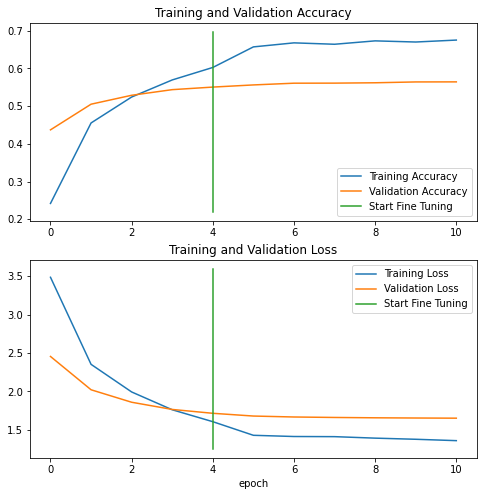

In [ ]:
compare_historys(history_common,
                 history_finetuned_next5,
                 initial_epochs=5)

comparing both results, one can notice that fine-tuning did improve accuracy and loss, there is still overfitting observed. However, when the feature extractor continued, the improvement in accuracy was only observed in the training set. With the fine tuning model, accuracy and losses reached were lower, but more consistent between training and validation dataset than the continued feature extractor.

When we include more data, we will have lesser issues with overfitting. since now we are using 10% of a dataset meant for 101 categories.

## Evaluate model training speed with mixed precision

In [ ]:
from tensorflow.keras import mixed_precision

# Set up mixed precision policy
policy = mixed_precision.Policy("float32")
mixed_precision.set_global_policy(policy)


In [ ]:
base_model.trainable = False

In [ ]:
model.load_weights("101_classes_10_percent_data_model_checkpoint")

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_mixed_precision = model.fit(train_data,
                                    epochs=10,
                                    validation_data=test_data,
                                    validation_steps=int(0.25*len(test_data)),
                                    initial_epoch=history_common.epoch[-1])

Epoch 5/10
237/237 [==============================] - 31s 103ms/step - loss: 1.4979 - accuracy: 0.6304 - val_loss: 1.6859 - val_accuracy: 0.5527
Epoch 6/10
237/237 [==============================] - 23s 96ms/step - loss: 1.3841 - accuracy: 0.6533 - val_loss: 1.6635 - val_accuracy: 0.5566
Epoch 7/10
237/237 [==============================] - 23s 96ms/step - loss: 1.3003 - accuracy: 0.6716 - val_loss: 1.6469 - val_accuracy: 0.5622
Epoch 8/10
237/237 [==============================] - 23s 97ms/step - loss: 1.1986 - accuracy: 0.7026 - val_loss: 1.6405 - val_accuracy: 0.5660
Epoch 9/10
237/237 [==============================] - 23s 97ms/step - loss: 1.1524 - accuracy: 0.7143 - val_loss: 1.6156 - val_accuracy: 0.5707
Epoch 10/10
237/237 [==============================] - 23s 96ms/step - loss: 1.0619 - accuracy: 0.7415 - val_loss: 1.6308 - val_accuracy: 0.5660


In [ ]:
mixed_precision_next = model.fit(train_data,
                                    epochs=20,
                                    validation_data=test_data,
                                    validation_steps=int(0.25*len(test_data)),
                                    initial_epoch=history_mixed_precision.epoch[-1])

Epoch 10/20
237/237 [==============================] - 23s 95ms/step - loss: 1.0218 - accuracy: 0.7459 - val_loss: 1.6486 - val_accuracy: 0.5627
Epoch 11/20
237/237 [==============================] - 23s 97ms/step - loss: 0.9726 - accuracy: 0.7585 - val_loss: 1.6452 - val_accuracy: 0.5654
Epoch 12/20
237/237 [==============================] - 23s 95ms/step - loss: 0.9336 - accuracy: 0.7679 - val_loss: 1.6433 - val_accuracy: 0.5650
Epoch 13/20
237/237 [==============================] - 23s 97ms/step - loss: 0.8785 - accuracy: 0.7831 - val_loss: 1.6270 - val_accuracy: 0.5714
Epoch 14/20
237/237 [==============================] - 23s 96ms/step - loss: 0.8460 - accuracy: 0.7888 - val_loss: 1.6280 - val_accuracy: 0.5712
Epoch 15/20
237/237 [==============================] - 23s 96ms/step - loss: 0.8121 - accuracy: 0.8046 - val_loss: 1.6234 - val_accuracy: 0.5712
Epoch 16/20
237/237 [==============================] - 23s 95ms/step - loss: 0.7839 - accuracy: 0.8100 - val_loss: 1.6515 - val_ac